In [1]:
# import all dependencies
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

# turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read health data from csv
health_df = pd.read_csv('obesity_diabetes_csv.csv')



In [3]:
# revise csv to show only needed columns
health_df = health_df[['LocationName', 'Data_Value', 'Geolocation', 'Short_Question_Text']]

# split geolocation column into long/lat columns
health_df[['point','Longitude', 'Latitude']] = health_df['Geolocation'].str.split(' ', expand=True)

#clean up new long/lat columns
health_df['Longitude'] = health_df['Longitude'].str.replace("(", "")
health_df['Latitude'] = health_df['Latitude'].str.replace(")", "")

health_df.head()




,LocationName,Data_Value,Geolocation,Short_Question_Text,point,Longitude,Latitude
0,73002,13.1,POINT (-97.73097606 34.94935021),Diabetes,POINT,-97.73097606,34.94935021
1,73002,40.6,POINT (-97.73097606 34.94935021),Obesity,POINT,-97.73097606,34.94935021
2,73003,8.9,POINT (-97.49717346 35.66897845),Diabetes,POINT,-97.49717346,35.66897845
3,73003,34.4,POINT (-97.49717346 35.66897845),Obesity,POINT,-97.49717346,35.66897845
4,73004,10.2,POINT (-97.905542 35.13636931),Diabetes,POINT,-97.905542,35.13636931


In [4]:
# Clean up! Delete unnecessary columns, rename columns for useability, and reorder columns
health_df = health_df.drop(['Geolocation', 'point'], axis=1)

In [5]:
# Rename columns for useability
health_df = health_df.rename(columns={"LocationName":"zip_code", "Short_Question_Text":"Indicator","Data_Value":"Obesity Rate"})

health_df.head()




,zip_code,Obesity Rate,Indicator,Longitude,Latitude
0,73002,13.1,Diabetes,-97.73097606,34.94935021
1,73002,40.6,Obesity,-97.73097606,34.94935021
2,73003,8.9,Diabetes,-97.49717346,35.66897845
3,73003,34.4,Obesity,-97.49717346,35.66897845
4,73004,10.2,Diabetes,-97.905542,35.13636931


In [6]:
#test
latitude = 36.11893133
longitude = -95.806359
zipcode = 74134
#parameters
categories = "public_transport"
radius = 8000

filters = f"circle:{longitude},{latitude},{radius}"
apikey = "1890ee6ad56e47b9aa37e9b6bdbfcf2f"

params = {
    "categories":categories,
    "filter":filters,
    "apiKey":apikey
    
}


base_url = "https://api.geoapify.com/v2/places"

response = requests.get(base_url, params=params)

transport_data = response.json()
print(json.dumps(transport_data, indent=4, sort_keys=True))


{
    "features": [
        {
            "geometry": {
                "coordinates": [
                    -95.8885968,
                    36.11412789974706
                ],
                "type": "Point"
            },
            "properties": {
                "address_line1": "Memorial Midtown Station",
                "address_line2": "East 33rd Street, Tulsa, OK 74145, United States of America",
                "categories": [
                    "public_transport",
                    "public_transport.bus"
                ],
                "city": "Tulsa",
                "country": "United States",
                "country_code": "us",
                "county": "Tulsa County",
                "datasource": {
                    "attribution": "\u00a9 OpenStreetMap contributors",
                    "license": "Open Database Licence",
                    "raw": {
                        "bus": "yes",
                        "highway": "bus_stop",
                        

In [7]:
#drop diabetes data
obesity_df = health_df.drop_duplicates(subset=['zip_code'], keep='last')

#add blank column to store count of public transport stops or stations
obesity_df["Transport Count"] = ""

obesity_df.head()


,zip_code,Obesity Rate,Indicator,Longitude,Latitude,Transport Count
1,73002,40.6,Obesity,-97.73097606,34.94935021,
3,73003,34.4,Obesity,-97.49717346,35.66897845,
5,73004,37.9,Obesity,-97.905542,35.13636931,
7,73005,45.0,Obesity,-98.23818097,35.05783297,
9,73006,43.1,Obesity,-98.40269923,34.90892372,


In [8]:
#find transport stops or stations within 5 miles (about 8000 m)

radius = 1600

categories = "public_transport"

params = {
    "categories":categories,
    "apiKey":apikey
}


for index, row in obesity_df.iterrows():
    
    latitude = obesity_df.loc[index, "Latitude"]
    longitude = obesity_df.loc[index, "Longitude"]
    
    params["filter"] = f"circle:{longitude},{latitude},{radius}"
    params["bias"] = f"proximity:{longitude},{latitude}"
    
    #set base url
    base_url = "https://api.geoapify.com/v2/places"
    
    #make request using params dictionary
    transport = requests.get(base_url, params=params)
    
    #convert to json
    transport = transport.json()
    
    #append list
    obesity_df.loc[index, "Transport Count"] = (len(transport["features"]))

    

In [9]:
# display sample of new DF
obesity_df.shape

(642, 6)

In [10]:
#Making 0.0 to 0.1 just for map 
obesity_df["Transport Count +0.1"] = ""

for index, row in obesity_df.iterrows():
    
    Transport_Count = obesity_df.loc[index, "Transport Count"]
    
    if obesity_df.loc[index, "Transport Count"] == 0.0:
        obesity_df.loc[index, "Transport Count +0.1"] = 0.1
        
    if obesity_df.loc[index, "Transport Count"] != 0.0:
        obesity_df.loc[index, "Transport Count +0.1"] = obesity_df.loc[index, "Transport Count"]
    




In [11]:
# convert to floats
obesity_df["Transport Count"] = obesity_df["Transport Count"].astype(float)
obesity_df["Transport Count +0.1"] = obesity_df["Transport Count +0.1"].astype(float)
obesity_df["Latitude"] = obesity_df["Latitude"].astype(float)
obesity_df["Longitude"] = obesity_df["Longitude"].astype(float)


In [12]:
# map
transport_map = obesity_df.hvplot.points("Longitude",
                                       "Latitude",
                                       geo = True,
                                       tiles = "OSM",
                                       size = "Transport Count +0.1",
                                       color = "Obesity Rate",
                                       hover_cols = ["zip_code", "Transport Count"])

transport_map


:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (Obesity Rate,Transport Count +0.1,zip_code,Transport Count)

In [13]:
#Make new df for averages
mean = obesity_df.groupby("Transport Count")["Obesity Rate"].mean()

mean_df= pd.DataFrame(mean)
mean_df = mean_df.reset_index()

mean_df



,Transport Count,Obesity Rate
0,0.0,41.032231
1,1.0,38.000000
2,2.0,43.850000
3,4.0,34.966667
4,5.0,44.000000
5,6.0,45.900000
6,8.0,43.300000
7,9.0,34.300000
8,13.0,35.200000
9,15.0,38.950000


<function matplotlib.pyplot.show(close=None, block=None)>

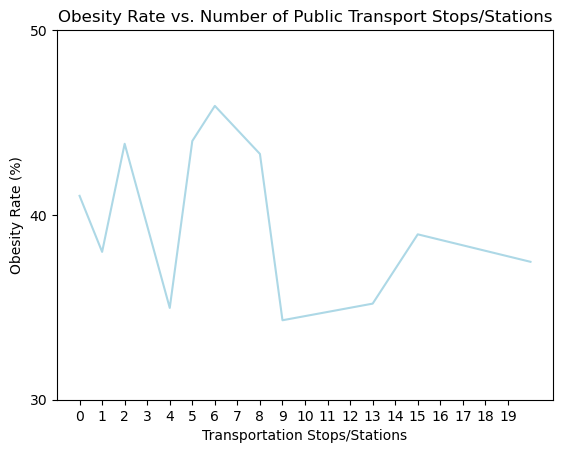

In [14]:
#Linegraph
mean_df["Transport Count"] = mean_df["Transport Count"].astype(float)
mean_df["Obesity Rate"] = mean_df["Obesity Rate"].astype(float)

plt.plot(mean_df["Transport Count"], mean_df["Obesity Rate"], color="lightblue")
plt.xlabel("Transportation Stops/Stations")
plt.ylabel("Obesity Rate (%)")
plt.title("Obesity Rate vs. Number of Public Transport Stops/Stations")
plt.xticks(np.arange(0,20, step=1))
plt.yticks(np.arange(30,55, step= 10))
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

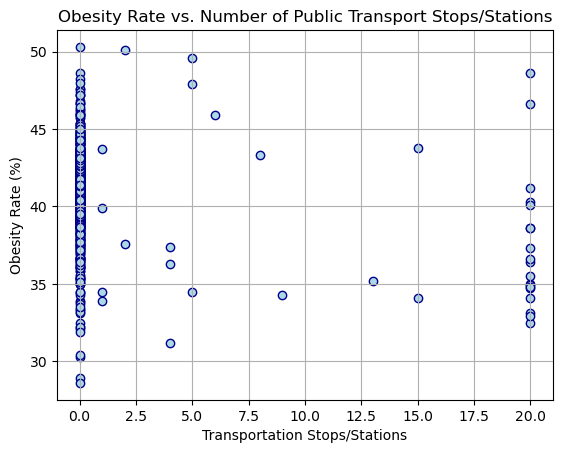

In [15]:
x_values = obesity_df["Transport Count"]
y_values = obesity_df["Obesity Rate"]
plt.scatter(x_values, y_values, c="lightblue", marker="o", edgecolors="darkblue")
plt.grid()
plt.xlabel("Transportation Stops/Stations")
plt.ylabel("Obesity Rate (%)")
plt.title("Obesity Rate vs. Number of Public Transport Stops/Stations")

plt.show


In [16]:
# scatter plots and linear regressions
# define a function for reg plots to use for diabetes and obesity

def reg_plot():
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values,c="lightblue", marker="o", edgecolors="darkblue")
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(100, 100),xycoords='figure pixels',fontsize=15,color="red")
    plt.xlabel('Transportation Stops/Stations')
    plt.ylabel(y_label)
    print(f"The correlation between amount of transportation stops/stations and the obesity rate is {rvalue**2}")
    plt.show()



The correlation between amount of transportation stops/stations and the obesity rate is 0.039898546163701275


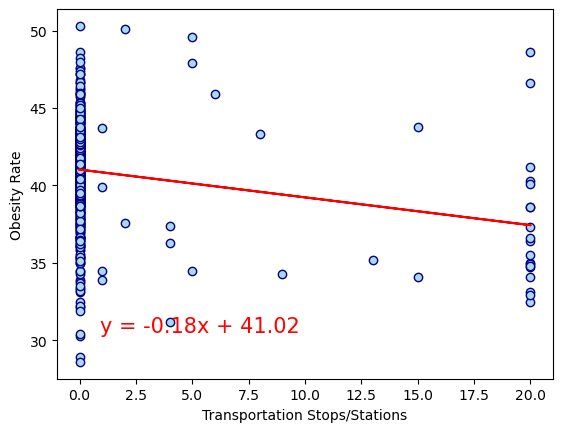

In [17]:
#linear regression- obesity
x_values = obesity_df['Transport Count']
y_values = obesity_df['Obesity Rate']
y_label =  "Obesity Rate"

reg_plot()


<function matplotlib.pyplot.show(close=None, block=None)>

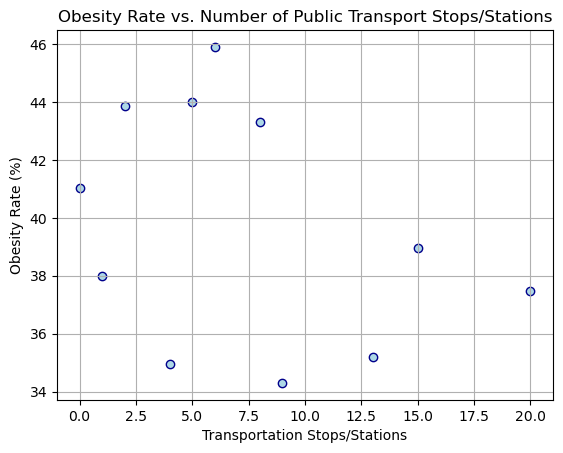

In [18]:
x_values = mean_df["Transport Count"]
y_values = mean_df["Obesity Rate"]
plt.scatter(x_values, y_values, c="lightblue", marker="o", edgecolors="darkblue")
plt.grid()
plt.xlabel("Transportation Stops/Stations")
plt.ylabel("Obesity Rate (%)")
plt.title("Obesity Rate vs. Number of Public Transport Stops/Stations")

plt.show


The correlation between amount of transportation stops/stations and the obesity rate is 0.12103815519263456


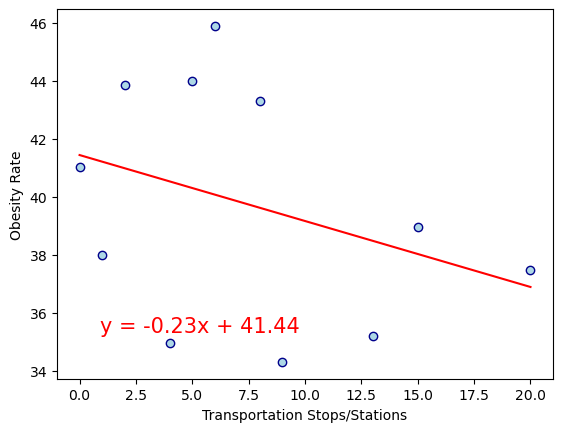

In [19]:
x_values = mean_df['Transport Count']
y_values = mean_df['Obesity Rate']
y_label =  "Obesity Rate"

reg_plot()


In [20]:
# Test

min_val = obesity_df["Transport Count"].min()
max_val = obesity_df["Transport Count"].max()

print(f"Transport counts range from {min_val} to {max_val}")



Transport counts range from 0.0 to 20.0


In [29]:
#make groups, drop groups without values (transport tation counts of 3,7,10,11,12,14,16,17,18,and 19)
group0 = obesity_df[obesity_df["Transport Count"] == 0]["Obesity Rate"]
group1 = obesity_df[obesity_df["Transport Count"] == 1]["Obesity Rate"]
group2 = obesity_df[obesity_df["Transport Count"] == 2]["Obesity Rate"]
group4 = obesity_df[obesity_df["Transport Count"] == 4]["Obesity Rate"]
group5 = obesity_df[obesity_df["Transport Count"] == 5]["Obesity Rate"]
group6 = obesity_df[obesity_df["Transport Count"] == 6]["Obesity Rate"]
group8 = obesity_df[obesity_df["Transport Count"] == 8]["Obesity Rate"]
group9 = obesity_df[obesity_df["Transport Count"] == 9]["Obesity Rate"]
group13 = obesity_df[obesity_df["Transport Count"] == 13]["Obesity Rate"]
group15 = obesity_df[obesity_df["Transport Count"] == 15]["Obesity Rate"]
group20 = obesity_df[obesity_df["Transport Count"] == 20]["Obesity Rate"]

# Anova Test
st.f_oneway(group0, group1, group2, group4, group5, group6, group8, group9,
            group13, group15, group20)

F_onewayResult(statistic=5.564698143522767, pvalue=5.604530850528749e-08)

In [25]:
#check group values
mean_df


,Transport Count,Obesity Rate
0,0.0,41.032231
1,1.0,38.000000
2,2.0,43.850000
3,4.0,34.966667
4,5.0,44.000000
5,6.0,45.900000
6,8.0,43.300000
7,9.0,34.300000
8,13.0,35.200000
9,15.0,38.950000


Text(0.5, 0, 'Obesity Rate')

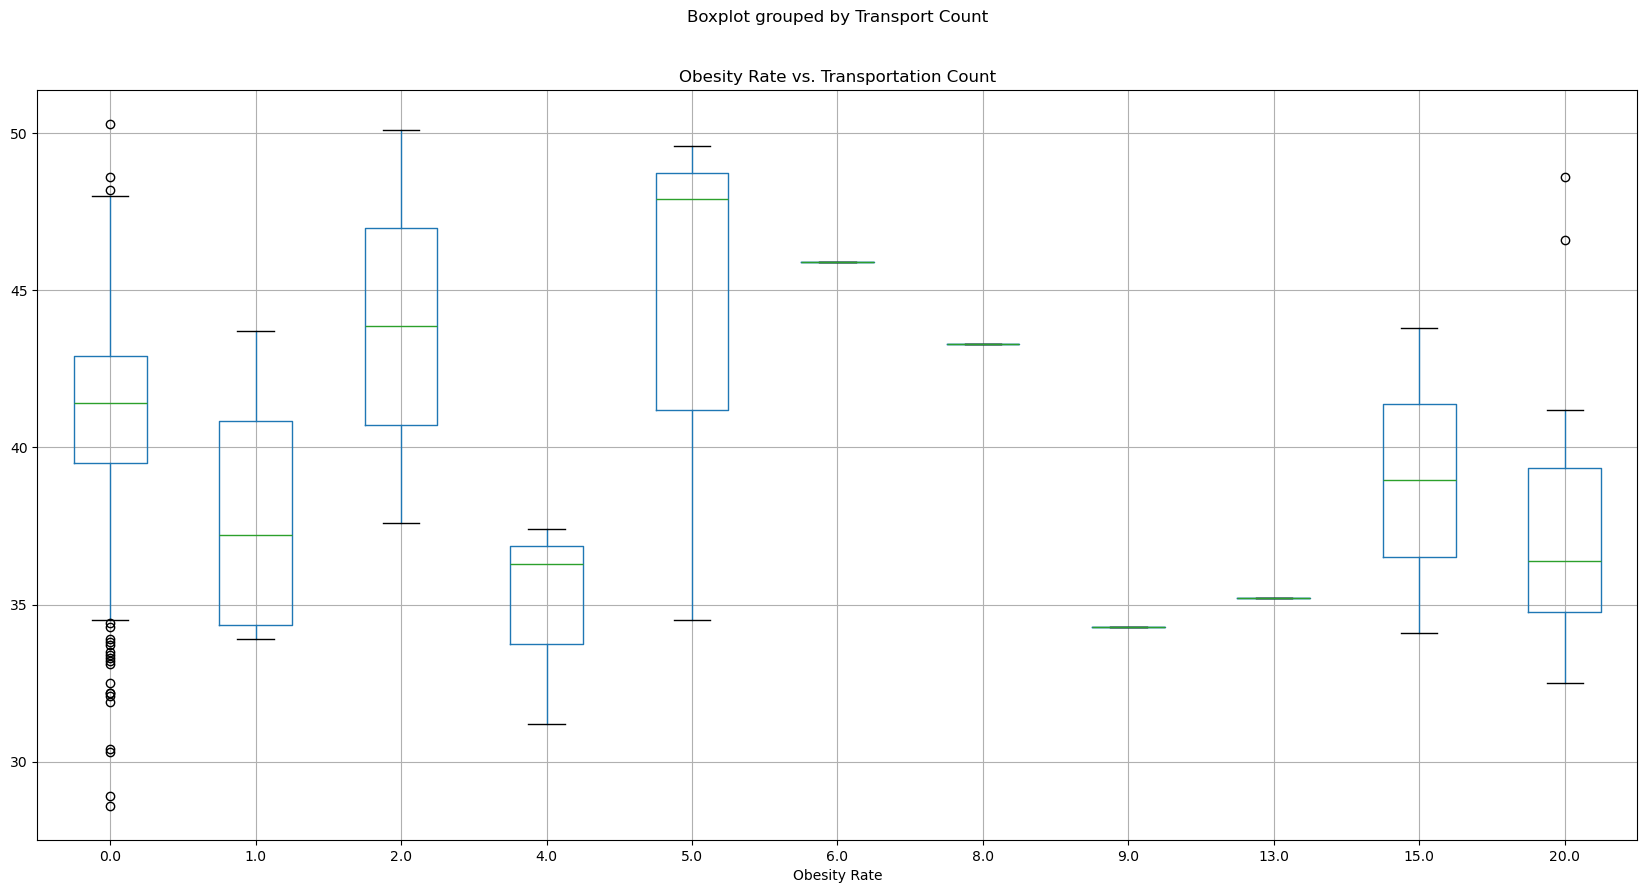

In [30]:
obesity_df.boxplot("Obesity Rate", by="Transport Count", figsize = (20,10))
plt.title('Obesity Rate vs. Transportation Count')
plt.xlabel('Obesity Rate')